<a href="https://colab.research.google.com/github/ricardoricrob76/machinelearning/blob/main/Web_Scraping_e_An%C3%A1lise_Estat%C3%ADstica_Participantes_de_Corridas_de_10KM_com_dados_de_sensores_RFID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Prof. Ricardo Roberto de Lima.


<strong><b><font size="5">Web Scraping e Análise de Dados</font></b></strong>

<strong><b><font size="5">Lab 2</font></b></strong>

<strong><b><font size="4">Web Scraping e Análise Estatística - Avaliando o Desempenho dos Participantes em Corridas de 10 KM com Dados de Sensores RFID</font></b></strong>

![title](imagens/lab2.png)

## Definição do Problema

Você gosta de correr? Corrida é um dos esportes mais praticados em todo mundo, além de uma atividade saudável e prazerosa.

Neste Lab vamos coletar dados reais de participantes de uma corrida de 10 KM realizada em Hillsboro no Oregon, EUA, em junho de 2017. 

Resumo da corrida:

- Pessoas que completaram a corrida: 577
- Homens: 414
- Mulheres: 163

O objetivo desta análise é encontrar:
    
- O tempo médio de conclusão da corrida.
- Se os tempos de chegada dos corredores seguem uma distribuição normal.
- Analisar se há diferença de desempenho entre homens e mulheres de várias faixas etárias.

Os tempos registrados na corrida (bem como outros dados) são bem precisos pois os participantes usaram sensores RFID de onde os dados foram extraídos e disponibilizados na web. Mais detalhes sobre o uso dos sensores RFID aqui:

https://www.hubertiming.com/runners/faq

## Fonte de Dados

Como fonte de dados usaremos o web site <a href="https://www.hubertiming.com/">Huber Timing</a> que contém o resultado das corridas que acontecem nos EUA, bem como a agenda de novos eventos.

Aqui a página com o resultado da corrida que faremos a análise:

https://www.hubertiming.com/results/2017GPTR10K

## Carregando os Pacotes Usados Neste Jupyter Notebook

In [ ]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.7.14


In [ ]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook, se necessário.

In [ ]:
# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

     |████████████████████████████████| 1.6 MB 8.5 MB/s 


In [ ]:
# Usaremos o pacote Pingouin para algumas das análises estatísticas
# https://pingouin-stats.org/index.html
!pip install -q pingouin

     |████████████████████████████████| 185 kB 10.5 MB/s 
     |████████████████████████████████| 9.8 MB 44.1 MB/s 


In [ ]:
# Imports
import re
import requests
import matplotlib as m
import numpy as np
import pandas as pd
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup as bs
from urllib.request import urlopen
from scipy import stats

# Imports para formatação dos gráficos
sns.set_style('whitegrid')
%matplotlib inline

In [ ]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

Author: Data Science Academy

pandas    : 1.3.5
requests  : 2.23.0
matplotlib: 3.2.2
scipy     : 1.7.3
pingouin  : 0.5.2
re        : 2.2.1
seaborn   : 0.11.2
numpy     : 1.21.6



## Web Scraping - Raspagem e ou coleta de dados Não Estruturados (HTML)...

In [ ]:
# Definindo a URL com o resultado da corrida
url = 'https://www.hubertiming.com/results/2017GPTR10K'

In [ ]:
# Abre a conexão com a url
html = urlopen(url)

In [ ]:
# Extrai o código HTML
soup = bs(html,'lxml')

In [ ]:
# Extrai o texto do código html
texto = soup.get_text()

In [ ]:
# Vamos visualizar as 10 primeiras linhas
linhas = soup.find_all('tr')
print(linhas[:15])

[<tr colspan="2">
<b>10K:</b>
</tr>, <tr>
<td>Finishers:</td>
<td>577</td>
</tr>, <tr>
<td>Male:</td>
<td>414</td>
</tr>, <tr>
<td>Female:</td>
<td>163</td>
</tr>, <tr class="header">
<th>Place</th>
<th>Bib</th>
<th>Name</th>
<th>Gender</th>
<th>City</th>
<th>State</th>
<th>Chip Time</th>
<th>Gun Time</th>
<th>Team</th>
</tr>, <tr data-bib="814">
<td>1</td>
<td>814</td>
<td>

                    JARED WILSON

                </td>
<td>M</td>
<td>TIGARD</td>
<td>OR</td>
<td>36:21</td>
<td>36:24</td>
<td></td>
</tr>, <tr data-bib="573">
<td>2</td>
<td>573</td>
<td>

                    NATHAN A SUSTERSIC

                </td>
<td>M</td>
<td>PORTLAND</td>
<td>OR</td>
<td>36:42</td>
<td>36:45</td>
<td>
<img class="lazy teamThumbs" data-src="/teamLogoThumbnail/logo?teamName=INTEL%20TEAM%20F&amp;raceId=1251&amp;state=OR"/>
                            INTEL TEAM F
                        </td>
</tr>, <tr data-bib="687">
<td>3</td>
<td>687</td>
<td>

                    FRANCISCO MAYA

      

## Limpeza e Transformação

Agora começa o trabalho pesado. Não fique apenas executando código e compreenda o que está sendo feito. Se tiver dificuldades, pergunte! Temos vários canais de suporte a sua disposição.

Começaremos obtendo todas as linhas da tabela em forma de lista e depois converteremos essa lista em um dataframe para facilitar a manipulação.

In [ ]:
# Loop
for linha in linhas:
    linha_td = linha.find_all('td')

In [ ]:
print(linha_td)

[<td>577</td>, <td>443</td>, <td>

                    LIBBY B MITCHELL

                </td>, <td>F</td>, <td>HILLSBORO</td>, <td>OR</td>, <td>1:41:18</td>, <td>1:42:10</td>, <td></td>]


Com expressões regulares em Python, vamos extrair os dados das tags HTML.

In [ ]:
# Lista vazia para receber as linhas
lista_linhas = []

In [ ]:
# Loop
for linha in linhas:
    cells = linha.find_all('td')
    str_cells = str(cells)
    clean = re.compile('<.*?>')
    clean2 = (re.sub(clean, '', str_cells))
    lista_linhas.append(clean2)

In [ ]:
print(clean2)

[577, 443, 

                    LIBBY B MITCHELL

                , F, HILLSBORO, OR, 1:41:18, 1:42:10, ]


Convertemos a lista em um dataframe e obtemos uma visão rápida das 10 primeiras linhas usando o Pandas.

In [ ]:
# Convertemos a lista em dataframe
df = pd.DataFrame(lista_linhas)

In [ ]:
df.head(10)

,0
0,[]
1,"[Finishers:, 577]"
2,"[Male:, 414]"
3,"[Female:, 163]"
4,[]
5,"[1, 814, \r\n\r\n JARED WIL..."
6,"[2, 573, \r\n\r\n NATHAN A ..."
7,"[3, 687, \r\n\r\n FRANCISCO..."
8,"[4, 623, \r\n\r\n PAUL MORR..."
9,"[5, 569, \r\n\r\n DEREK G O..."


Claramente precisamos limpar os dados. Vamos ao trabalho.

In [ ]:
# Dividindo cada linha e separando os dados a cada vírgula
df1 = df[0].str.split(',', expand = True)

In [ ]:
df1.head(10)

,0,1,2,3,4,5,6,7,8
0,[],None,None,None,None,None,None,None,None
1,[Finishers:,577],None,None,None,None,None,None,None
2,[Male:,414],None,None,None,None,None,None,None
3,[Female:,163],None,None,None,None,None,None,None
4,[],None,None,None,None,None,None,None,None
5,[1,814,\r\n\r\n JARED WILSON\r\n\...,M,TIGARD,OR,36:21,36:24,]
6,[2,573,\r\n\r\n NATHAN A SUSTERSI...,M,PORTLAND,OR,36:42,36:45,\n\r\n INTEL TEAM ...
7,[3,687,\r\n\r\n FRANCISCO MAYA\r\...,M,PORTLAND,OR,37:44,37:48,]
8,[4,623,\r\n\r\n PAUL MORROW\r\n\r...,M,BEAVERTON,OR,38:34,38:37,]
9,[5,569,\r\n\r\n DEREK G OSBORNE\r...,M,HILLSBORO,OR,39:21,39:24,\n\r\n INTEL TEAM ...


Está começando a ficar bonito. Vamos fazer mais algumas limpezas. Leia e compreenda o código. Se tiver dúvidas, pergunte (embora isso não deva ser novidade se você fez o curso gratuito de <a href="https://www.datascienceacademy.com.br/course?courseid=python-fundamentos">Python Fundamentos</a> aqui na DSA).

In [ ]:
# Removemos colchetes de abertura (lado esquerdo) do texto
df1[0] = df1[0].str.strip('[')

In [ ]:
df1.head(10)

,0,1,2,3,4,5,6,7,8
0,],None,None,None,None,None,None,None,None
1,Finishers:,577],None,None,None,None,None,None,None
2,Male:,414],None,None,None,None,None,None,None
3,Female:,163],None,None,None,None,None,None,None
4,],None,None,None,None,None,None,None,None
5,1,814,\r\n\r\n JARED WILSON\r\n\...,M,TIGARD,OR,36:21,36:24,]
6,2,573,\r\n\r\n NATHAN A SUSTERSI...,M,PORTLAND,OR,36:42,36:45,\n\r\n INTEL TEAM ...
7,3,687,\r\n\r\n FRANCISCO MAYA\r\...,M,PORTLAND,OR,37:44,37:48,]
8,4,623,\r\n\r\n PAUL MORROW\r\n\r...,M,BEAVERTON,OR,38:34,38:37,]
9,5,569,\r\n\r\n DEREK G OSBORNE\r...,M,HILLSBORO,OR,39:21,39:24,\n\r\n INTEL TEAM ...


In [ ]:
# Extraímos o cabeçalho de todas as tabelas no código HTML
col_labels = soup.find_all('th')

In [ ]:
col_labels

[<th>Place</th>,
 <th>Bib</th>,
 <th>Name</th>,
 <th>Gender</th>,
 <th>City</th>,
 <th>State</th>,
 <th>Chip Time</th>,
 <th>Gun Time</th>,
 <th>Team</th>]

In [ ]:
# Extraímos texto entre tags html dos cabeçalhos de tabela (extraímos o nome)
all_header = []
col_str = str(col_labels)
cleantext2 = bs(col_str, "lxml").get_text()
all_header.append(cleantext2)

In [ ]:
print(all_header)

['[Place, Bib, Name, Gender, City, State, Chip Time, Gun Time, Team]']


In [ ]:
# Convertendo a lista de cabeçalhos em um dataframe do pandas
df2 = pd.DataFrame(all_header)

In [ ]:
df2.head()

,0
0,"[Place, Bib, Name, Gender, City, State, Chip T..."


In [ ]:
# Dividindo a coluna "0" em várias colunas na posição de vírgula para todas as linhas
df3 = df2[0].str.split(',', expand = True)

In [ ]:
df3.head()

,0,1,2,3,4,5,6,7,8
0,[Place,Bib,Name,Gender,City,State,Chip Time,Gun Time,Team]


In [ ]:
# Concatenando os 2 dataframes
frames = [df3, df1]
df4 = pd.concat(frames)

In [ ]:
df4.head(10)

,0,1,2,3,4,5,6,7,8
0,[Place,Bib,Name,Gender,City,State,Chip Time,Gun Time,Team]
0,],None,None,None,None,None,None,None,None
1,Finishers:,577],None,None,None,None,None,None,None
2,Male:,414],None,None,None,None,None,None,None
3,Female:,163],None,None,None,None,None,None,None
4,],None,None,None,None,None,None,None,None
5,1,814,\r\n\r\n JARED WILSON\r\n\...,M,TIGARD,OR,36:21,36:24,]
6,2,573,\r\n\r\n NATHAN A SUSTERSI...,M,PORTLAND,OR,36:42,36:45,\n\r\n INTEL TEAM ...
7,3,687,\r\n\r\n FRANCISCO MAYA\r\...,M,PORTLAND,OR,37:44,37:48,]
8,4,623,\r\n\r\n PAUL MORROW\r\n\r...,M,BEAVERTON,OR,38:34,38:37,]


In [ ]:
# Atribuindo a primeira coluna como cabeçalho
df5 = df4.rename(columns = df4.iloc[0])

In [ ]:
df5.head()

,[Place,Bib,Name,Gender,City,State,Chip Time,Gun Time,Team]
0,[Place,Bib,Name,Gender,City,State,Chip Time,Gun Time,Team]
0,],None,None,None,None,None,None,None,None
1,Finishers:,577],None,None,None,None,None,None,None
2,Male:,414],None,None,None,None,None,None,None
3,Female:,163],None,None,None,None,None,None,None


In [ ]:
# Shape
df5.shape

(583, 9)

In [ ]:
# Obtendo uma visão geral dos dados para análise
df5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 583 entries, 0 to 581
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   [Place      583 non-null    object
 1    Bib        581 non-null    object
 2    Name       578 non-null    object
 3    Gender     578 non-null    object
 4    City       578 non-null    object
 5    State      578 non-null    object
 6    Chip Time  578 non-null    object
 7    Gun Time   578 non-null    object
 8    Team]      578 non-null    object
dtypes: object(9)
memory usage: 45.5+ KB


In [ ]:
# Verificando valores ausentes
df5.isnull().sum()

[Place        0
 Bib          2
 Name         5
 Gender       5
 City         5
 State        5
 Chip Time    5
 Gun Time     5
 Team]        5
dtype: int64

In [ ]:
# Removendo todas as linhas com valores ausentes
df6 = df5.dropna(axis = 0, how = 'any')

In [ ]:
# Descartando o cabeçalho da tabela replicada como a primeira linha no df5
df7 = df6.drop(df6.index[0])

In [ ]:
# Renomeando as colunas [Place e Team] 
df7.rename(columns = {'[Place': 'Place'}, inplace = True)
df7.rename(columns = {' Team]': 'Team'}, inplace = True)

In [ ]:
# Limpeza final dos dados - remoção do colchete de fechamento das células na coluna "Team".
df7['Team'] = df7['Team'].str.strip(']')

In [ ]:
df7.head()

,Place,Bib,Name,Gender,City,State,Chip Time,Gun Time,Team
5,1,814,\r\n\r\n JARED WILSON\r\n\...,M,TIGARD,OR,36:21,36:24,
6,2,573,\r\n\r\n NATHAN A SUSTERSI...,M,PORTLAND,OR,36:42,36:45,\n\r\n INTEL TEAM ...
7,3,687,\r\n\r\n FRANCISCO MAYA\r\...,M,PORTLAND,OR,37:44,37:48,
8,4,623,\r\n\r\n PAUL MORROW\r\n\r...,M,BEAVERTON,OR,38:34,38:37,
9,5,569,\r\n\r\n DEREK G OSBORNE\r...,M,HILLSBORO,OR,39:21,39:24,\n\r\n INTEL TEAM ...


## Análise de Dados

In [ ]:
# Convertendo a coluna "Chip Time" em apenas minutos
# Chip time é o tempo total de corrida medido com a leitura do sensor RFID no selo da camisa do participante
time_list = df7[' Chip Time'].tolist()

In [ ]:
# Visualizando uma amostra de dados
time_list[1:5]

[' 36:42', ' 37:44', ' 38:34', ' 39:21']

In [ ]:
# Lista para receber o resultado da conversão
time_mins = []

In [ ]:
# Loop para conversão
for i in time_list:
    i = i.strip(' ')
    if len(i)!=7:
        i = '0:' + i
    h, m, s = i.split(':')
    math = (int(h) * 3600 + int(m) * 60 + int(s))/60
    time_mins.append(math)

Convertendo a lista novamente em um dataframe e criamos uma nova coluna ("Runner_mins") como tempo total de corrida, mas agora em minutos.

In [ ]:
# Nova coluna
df7['Runner_mins'] = time_mins

In [ ]:
df7.head()

,Place,Bib,Name,Gender,City,State,Chip Time,Gun Time,Team,Runner_mins
5,1,814,\r\n\r\n JARED WILSON\r\n\...,M,TIGARD,OR,36:21,36:24,,36.350000
6,2,573,\r\n\r\n NATHAN A SUSTERSI...,M,PORTLAND,OR,36:42,36:45,\n\r\n INTEL TEAM ...,36.700000
7,3,687,\r\n\r\n FRANCISCO MAYA\r\...,M,PORTLAND,OR,37:44,37:48,,37.733333
8,4,623,\r\n\r\n PAUL MORROW\r\n\r...,M,BEAVERTON,OR,38:34,38:37,,38.566667
9,5,569,\r\n\r\n DEREK G OSBORNE\r...,M,HILLSBORO,OR,39:21,39:24,\n\r\n INTEL TEAM ...,39.350000


In [ ]:
df7.dtypes

Place           object
 Bib            object
 Name           object
 Gender         object
 City           object
 State          object
 Chip Time      object
 Gun Time       object
Team            object
Runner_mins    float64
dtype: object

In [ ]:
# Cálculo de estatísticas para colunas numéricas no dataframe
df7.describe(include = [np.number])

,Runner_mins
count,577.000000
mean,60.035933
std,11.970623
min,36.350000
25%,51.000000
50%,59.016667
75%,67.266667
max,101.300000


**Análise**:

- O tempo médio de chip para todos os corredores foi de ~ 60 minutos (a média na tabela acima).
- O corredor 10K mais rápido terminou em 36,35 minutos (valor mínimo na tabela acima).
- O corredor mais lento terminou em 101,30 minutos (valor máximo na tabela acima).

Vamos criar um boxplot para sumarizar nossa análise.

/usr/local/lib/python3.7/dist-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


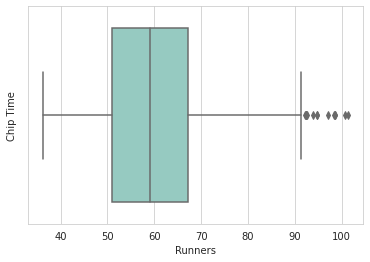

In [ ]:
# Plot
ax = sns.boxplot(x = df7["Runner_mins"], palette = "Set3", orient = "v")
plt.ylabel('Chip Time')
plt.xlabel('Runners')
plt.show()

Acima estão as estatísticas de resumo de dados para os corredores mostrados em um boxplot: Máximo, mínimo, médio, primeiro quartil, terceiro quartil, incluindo valores extremos.

Criaremos agora um gráfico de distribuição dos tempos dos chips dos corredores usando a biblioteca seaborn.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


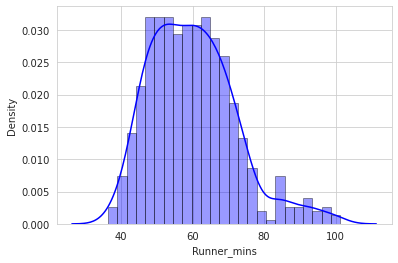

In [ ]:
# Plot
x = df7['Runner_mins']
ax = sns.distplot(x, hist = True, kde = True, rug = False, color = 'blue', bins = 25, hist_kws = {'edgecolor':'black'})
plt.show()

A distribuição da variável parece quase normal. Mas vamos realizar um teste estatístico para confirmar.

Um ponto de decisão importante ao trabalhar com uma amostra de dados é usar métodos estatísticos paramétricos ou não paramétricos.

Os métodos estatísticos paramétricos assumem que os dados têm uma distribuição conhecida e específica, geralmente uma distribuição gaussiana (normal). Se uma amostra de dados não é gaussiana, as suposições dos testes estatísticos paramétricos são violadas e métodos estatísticos não paramétricos devem ser utilizados.

Há várias técnicas que você pode usar para verificar se sua amostra de dados se desvia de uma distribuição gaussiana, chamada testes de normalidade.

O pacote stats do SciPy fornece uma função para um dos testes de normalidade mais comuns, o Shapiro-Wilk Test. Usaremos ainda a função normality do pacote Pengouin.

O Shapiro-Wilk é um teste de hipóteses, que testa essas duas hipóteses:

**A hipótese nula deste teste é que a população é normalmente distribuída. Assim, se o valor-p for menor que o nível alfa escolhido (normalmente definido em 0,05), a hipótese nula será rejeitada e há evidências de que os dados testados não são normalmente distribuídos.**

O resultado do teste de Shapiro-Wilk deve ser interpretado com cautela no caso de amostras grandes. 

In [ ]:
# Valor de x
x = df7['Runner_mins']

In [ ]:
# Teste de normalidade com Scipy
stats.shapiro(x)

ShapiroResult(statistic=0.9625251889228821, pvalue=5.836563177208376e-11)

In [ ]:
# Teste de normalidade com Pingouin
pg.normality(x)

,W,pval,normal
Runner_mins,0.962525,5.836563e-11,False


**Análise**:

- A variável não segue uma distribuição normal, uma vez que o valor-p é menor que 0.05 e assim há evidências estatísticas para rejeitar a hipótese nula. A função normality() do pacote Pingouin coloca essa informação na última coluna.

Vamos agora descobrir se houve alguma diferença de desempenho entre homens e mulheres de várias faixas etárias.

In [ ]:
# Separando os dados
f_runners = df7.loc[df7[' Gender'] == ' F']['Runner_mins']
m_runners = df7.loc[df7[' Gender'] == ' M']['Runner_mins']

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


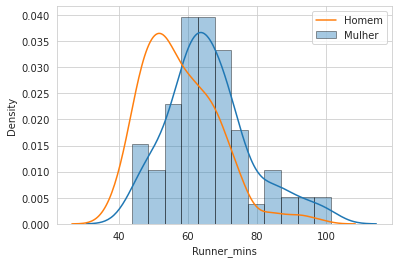

In [ ]:
# Criaremos os 2 plots em uma só figura para facilitar a comparação
sns.distplot(f_runners, hist = True, kde = True, rug = False, hist_kws = {'edgecolor':'black'}, label = 'Mulher')
sns.distplot(m_runners, hist = False, kde = True, rug = False, hist_kws = {'edgecolor':'black'}, label = 'Homem')
plt.legend()

**Análise**:

- A distribuição indica que as mulheres eram mais lentas que os homens, em média.

In [ ]:
# Computando estatísticas resumidas para homens e mulheres separadamente usando o método groupby ()
g_stats = df7.groupby(" Gender", as_index = True).describe()
g_stats

Runner_mins                                                         \
              count       mean        std        min        25%        50%   
 Gender                                                                      
 F            163.0  66.119223  12.184440  43.766667  58.758333  64.616667   
 M            414.0  57.640821  11.011857  36.350000  49.395833  55.791667   

                                
               75%         max  
 Gender                         
 F       72.058333  101.300000  
 M       64.804167   98.516667

**Análise**:
    
- O tempo médio de chip para todas as mulheres e homens foi de ~ 66 minutos e ~ 58 minutos, respectivamente, comprovando a análise do gráfico. 

Um boxplot ajuda a comparar as amostras de homens e mulheres.

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


Text(0.5, 0.98, '')

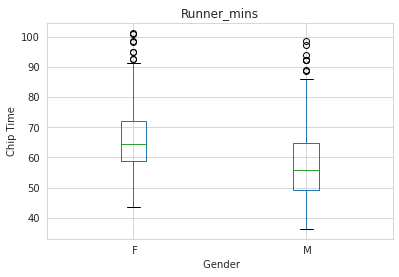

In [ ]:
# Plot
df7.boxplot(column = 'Runner_mins', by = ' Gender')
plt.ylabel('Chip Time')
plt.suptitle("")

Nossa fonte de dados possui resultados de diversas corridas. Material em abundância para você praticar seus conhecimentos em análise de dados.

# Fim